In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import math   
import random   
import copy
import gmsh
import MEF
from matplotlib import quiver
plt.rc('figure', figsize=(15,8))
plt.rc('font',size=22) 

In [2]:
gmsh.initialize()

Info    : Increasing process stack size (8192 kB < 16 MB)


In [3]:
gmsh.model.add('Chapa agujereada') 

## Datos

In [4]:
l= 20
h= 10
t=1
radio_aguj= 1
T= 1000
E= 30E6
v_po = 0.3
fe = 0.25 #factor de escala #variando este número cambio la cantidad de elementos
glxn=2

In [5]:
D= (E/(1-v_po**2))*np.array([[1,v_po,0],[v_po,1,0],[0,0,(1-v_po)/2]])

Solamente un cuarto de la chapa, el resto sale por simetria.

In [6]:
p1= gmsh.model.geo.addPoint(0,0,0,fe) #no pertenece a la chapa)
p2= gmsh.model.geo.addPoint(radio_aguj,0,0,fe/15) #(comienza la chapa en X)
p3= gmsh.model.geo.addPoint(l/2,0,0,fe)
p4= gmsh.model.geo.addPoint(l/2,h/2,0,fe)
p5= gmsh.model.geo.addPoint(0,h/2,0,fe)
p6= gmsh.model.geo.addPoint(0,radio_aguj,0,fe/15)

In [7]:
l1= gmsh.model.geo.addLine(p2,p3)
l2= gmsh.model.geo.addLine(p3,p4)
l3= gmsh.model.geo.addLine(p4,p5)
l4= gmsh.model.geo.addLine(p5,p6)
l5= gmsh.model.geo.addCircleArc(p6,p1,p2)

In [8]:
C1= gmsh.model.geo.addCurveLoop([l1,l2,l3,l4,l5])

In [9]:
S1= gmsh.model.geo.addPlaneSurface([C1])

In [10]:
empotrado_horizontal = gmsh.model.addPhysicalGroup(1,[l1]) #el 1 dice que es de 1 dimension
gmsh.model.setPhysicalName(1,empotrado_horizontal,'empotrado horizontal')

empotrado_vertical = gmsh.model.addPhysicalGroup(1,[l4]) #el 1 dice que es de 1 dimension
gmsh.model.setPhysicalName(1,empotrado_vertical,'empotrado vertical')

In [11]:
traccionado = gmsh.model.addPhysicalGroup(1,[l2]) #el 1 dice que es de 1 dimension
gmsh.model.setPhysicalName(1,traccionado,'traccionado')

In [12]:
superficie = gmsh.model.addPhysicalGroup(2,[S1]) #el 1 dice que es de 1 dimension
gmsh.model.setPhysicalName(1,superficie,'superficie')

In [13]:
gmsh.model.geo.synchronize()

In [14]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Circle)
Info    : Done meshing 1D (Wall 0.0117502s, CPU 0.028354s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0817107s, CPU 0.151233s)
Info    : 4336 nodes 8674 elements


In [15]:
gmsh.model.geo.synchronize()

In [16]:
#mdfcomment gmsh.fltk.run() estoy revisando en remote
def mpl_mesh_plot(mn, mc):
    fig, ax = plt.subplots()
    ax.triplot(mn[:,0], mn[:,1], mc)
    return fig, ax

In [17]:
NodeInfo = gmsh.model.mesh.get_nodes()
Nn = NodeInfo[0].shape[0]
MN = NodeInfo[1].reshape(Nn,3)

In [18]:
MN=MN[1:,:]
MN= np.append(MN,np.zeros([1,3]),0)

In [19]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)
Ne = ETAGS.shape[0]
Nnxe = 3
MC = ELEMENTS.reshape(Ne,Nnxe)
MC = MC - np.ones([Ne,Nnxe])
MC = MC.astype(int)

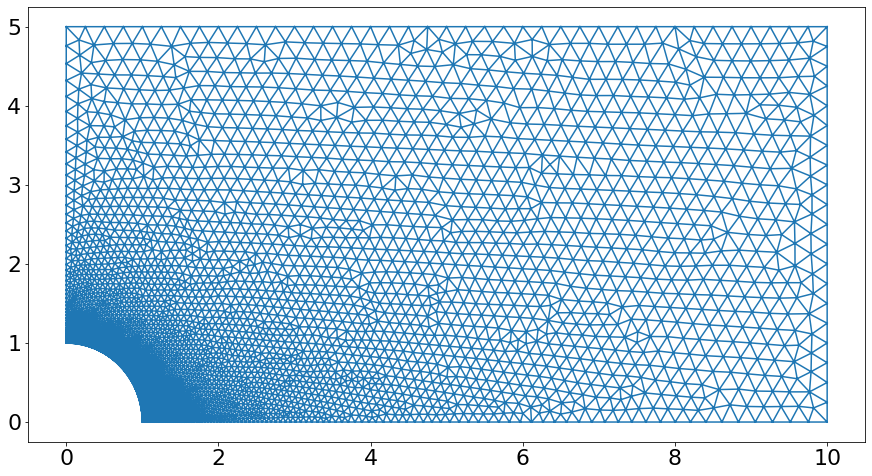

In [20]:
fig, ax = mpl_mesh_plot(MN, MC)

In [21]:
#igual a la del ejercicio 1
alpha = []
beta= []
gamma=[]
Area=[]
B={}
K={}
for i in range(Ne):
    nodos= MC[i,:]
    alpha.append(MN[nodos[1],0]*MN[nodos[2],1]-MN[nodos[2],0]*MN[nodos[1],1])
    alpha.append(MN[nodos[0],0]*MN[nodos[2],1]-MN[nodos[2],0]*MN[nodos[0],1])
    alpha.append(MN[nodos[0],0]*MN[nodos[1],1]-MN[nodos[1],0]*MN[nodos[0],1])
    beta.append(MN[nodos[1],1]-MN[nodos[2],1])
    beta.append(MN[nodos[2],1]-MN[nodos[0],1])
    beta.append(MN[nodos[0],1]-MN[nodos[1],1])
    gamma.append(MN[nodos[2],0]-MN[nodos[1],0])
    gamma.append(MN[nodos[0],0]-MN[nodos[2],0])
    gamma.append(MN[nodos[1],0]-MN[nodos[0],0])
    Area.append((alpha[0+i*Nnxe]-alpha[1+i*Nnxe]+alpha[2+i*Nnxe])/2)
    B[i]=(1/(2*Area[i]))* np.array([
        [beta[Nnxe*i+0],0,beta[Nnxe*i+1],0,beta[Nnxe*i+2],0],[0,gamma[Nnxe*i+0],0,gamma[Nnxe*i+1],0,gamma[Nnxe*i+2]],
        [gamma[Nnxe*i+0],beta[Nnxe*i+0],gamma[Nnxe*i+1],beta[Nnxe*i+1],gamma[Nnxe*i+2],beta[Nnxe*i+2]]])

    K[i]=t*np.abs(Area[i])*np.transpose(B[i]).dot(D.dot(B[i]))

In [22]:
Kglobal = np.zeros([Nn*glxn,Nn*glxn])

In [23]:
archivo= 'Matrices_elementales_ejercicio2_G3.txt'
with open(archivo,'w') as f:
    f.write('Matrices Elementales\n ===============')
archivo1= 'Matriz_global.txt'
with open(archivo1,'w') as f:
    f.write('Matriz Global\n ===============')

<div style="background:#999900"> cada vez que haces copy paste de un loop así me da un escalofrío. </div>

In [24]:
for e in range(Ne):
    fe1 = np.abs(K[e].max()) #factor de escala
    with open(archivo,'a') as f:
        f.write(f'\nelemento {e}, fe ={fe1:4e}\n')
        f.write(f'{K[e]/fe1}\n')
    

    for i in range(Nnxe):
        rangoi= np.linspace(i*glxn,(i+1)*glxn-1,glxn, dtype = "int")
        rangoni= np.linspace(MC[e,i]*glxn,(MC[e,i]+1)*glxn-1,glxn, dtype = "int")
        for j in range(Nnxe):
            rangoj= np.linspace(j*glxn,(j+1)*glxn-1,glxn, dtype = "int")
            rangonj= np.linspace(MC[e,j]*glxn,(MC[e,j]+1)*glxn-1,glxn, dtype = "int")
            Kglobal[np.ix_(rangoni,rangonj)] += K[e][np.ix_(rangoi,rangoj)]

In [25]:
nodos_emp_horizontal, xyz_emp_horizontal = gmsh.model.mesh.getNodesForPhysicalGroup(1, empotrado_horizontal)
nodos_emp_vertical, xyz_emp_vertical = gmsh.model.mesh.getNodesForPhysicalGroup(1, empotrado_vertical)

In [26]:
s = []
for n in nodos_emp_vertical-1:
    s.append(glxn*n)
for n in nodos_emp_horizontal-1:
    s.append(glxn*n + 1)

# ESTO lo hago por tener el punto (0,0,0) al final del todo, así puedo empotrarlo y resolver el ejercicio. CUANDO CORRIJA
# EL PROGRAMA, debería borrar estas dos líneas.
s.append((NodeInfo[0][0]-1)*glxn)
s.append((NodeInfo[0][0]-1)*glxn + 1)

s = np.array(s).astype(int)

Us = np.zeros([s.shape[0]]).reshape([-1,1])

r = np.array([i for i in range(Nn*glxn) if i not in s])

In [27]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, traccionado)

Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])

Nlineastraccionadas = len(Ttraccionada[0])

MCtraccionadas = Ltraccionada[0].reshape(Nlineastraccionadas,2) - 1

In [28]:
Fr = np.zeros_like(r)
for e in range(Nlineastraccionadas):
    nodos = MCtraccionadas[e,:].astype(int)
    Ltraccionado = abs(MN[nodos[1],1]-MN[nodos[0],1])
    Fr[np.where(r == nodos[0]*2)[0][0]] += T*t*Ltraccionado/2
    Fr[np.where(r == nodos[1]*2)[0][0]] += T*t*Ltraccionado/2
Fr = Fr.reshape([-1,1])

In [29]:
U, F = MEF.solve1D(Kglobal,s,r,Us,Fr)

In [30]:
despl=[]
des_xy= U.reshape(Nn,2)
despl_xyz= np.hstack([des_xy,np.zeros([Nn,1])])

In [31]:
despl_xyz.shape

(4336, 3)

In [32]:
MN_final = MN + despl_xyz

In [33]:
despl_elemento={}
tension={}
for i in range(Ne):
    despl_elemento[i]= despl_xyz[MC[i],:2].ravel().reshape(-1,1)
    #despl_elemento[i].ravel().reshape(-1,1)
    tension[i]= D.dot(B[i].dot(despl_elemento[i]))

Text(0.5, 0, 'y (in)')

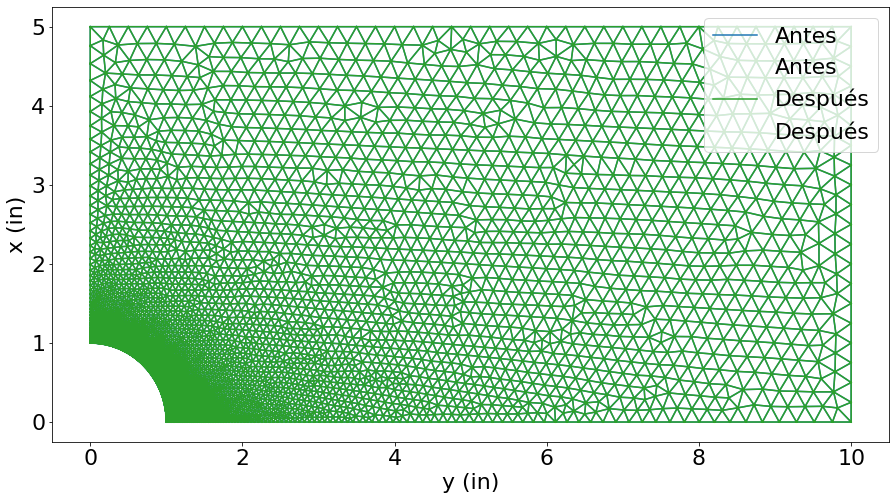

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
plt.triplot(MN[:,0], MN[:,1], MC, label='Antes')
plt.triplot(MN_final[:,0], MN_final[:,1], MC, label='Después')
plt.legend()
plt.ylabel('x (in)')
plt.xlabel('y (in)')

Text(0, 0.5, 'y (in)')

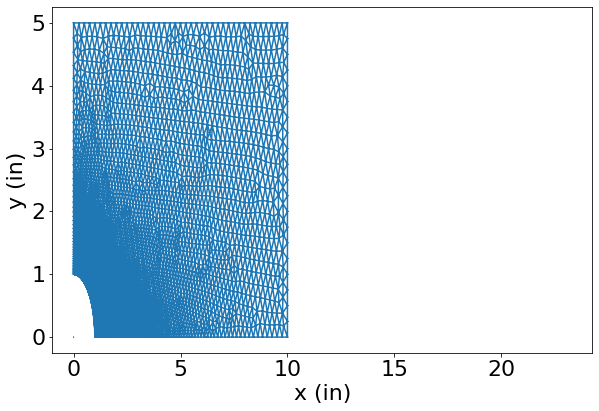

In [35]:
Fx = F[2*np.arange(Nn)]
Fy = F[2*np.arange(Nn)+1]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
ax.quiver( MN[:,0], MN[:,1], Fx, Fy, linewidth=5, units='width', scale=1e5)   # Flechas
ax.set_xlim(-1, 1.2*l+(Fx/1e3).max())
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

In [36]:
desps = gmsh.view.add("Desplazamientos")

In [37]:
Desps = gmsh.view.addModelData(desps, 0, 'Chapa agujereada', 'NodeData', NodeInfo[0]+1, despl_xyz, numComponents=3)

In [38]:
gmsh.option.setNumber(f'View[{desps}].VectorType',5)

In [39]:
Fxyz = np.hstack((Fx,Fy, np.zeros((Nn,1))))

In [40]:
fx = gmsh.view.add("Fuerzas")

In [41]:
Fz = gmsh.view.addModelData(fx, 0, 'Chapa agujereada','NodeData',NodeInfo[0]+1, Fxyz, numComponents=3)

In [42]:
gmsh.option.setNumber(f'View[{fx}].VectorType',4)

In [43]:
gmsh.option.setNumber(f'View[{fx}].GlyphLocation',2)

In [44]:
tensiones_123= np.hstack(list(tension.values()))

In [45]:
sigX = gmsh.view.add("Tensiones en X")

In [46]:
TensionesX = gmsh.view.addModelData(sigX, 0, 'Chapa agujereada', 'ElementData', ETAGS, tensiones_123[0,:].reshape([-1,1]) , numComponents=1 )

In [47]:
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.write('TestMeshView_IN.msh')

Info    : Writing 'TestMeshView_IN.msh'...
Info    : Done writing 'TestMeshView_IN.msh'


In [48]:
#gmsh.view.write(1,"TestMeshView_OUT.msh",append=True)

In [49]:
gmsh.model.geo.synchronize()

In [50]:
#mdfcomment gmsh.fltk.run() estoy revisando en remote

In [51]:
def plot_forces_wmpl(mn, f, ax=None, fig=None):
    if ax is  None:
        fig,ax = plt.subplots()
    selection = (np.abs(f[:,0]) > 0) | (np.abs(f[:,1])>0)
    plt.quiver(mn[selection,0], mn[selection,1], f[selection,0], np.zeros_like(f[selection,0]),scale=200, scale_units='x')
    plt.quiver(mn[selection,0], mn[selection,1], np.zeros_like(f[selection,1]), f[selection,1],scale=10, scale_units='y')
    return fig, ax

def plot_stress_wmpl(mn, mc, stress, label, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    mapp = ax.tripcolor(mn[:,0], mn[:,1], mc, facecolors=stress)
    cbar = plt.colorbar(mapp, ax=ax)
    cbar.set_label(label)
    return fig, ax

(-2.0, 7.0)

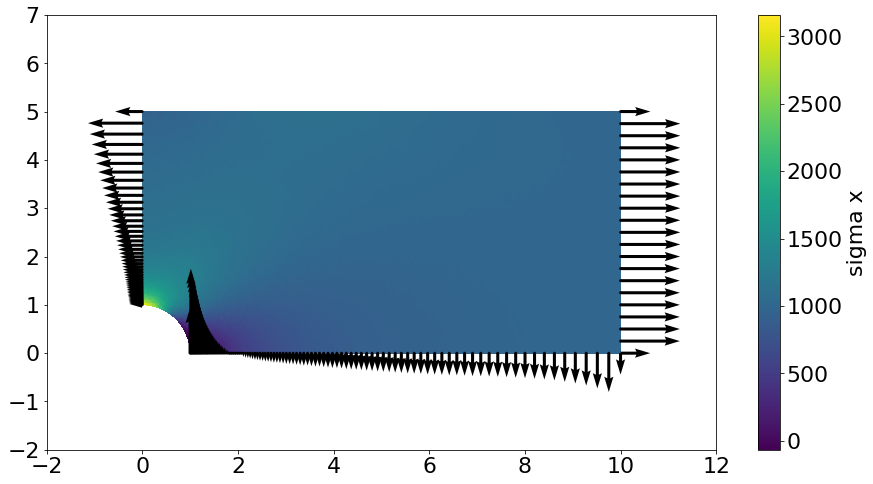

In [52]:
fig, ax = plot_stress_wmpl(MN_final, MC, tensiones_123[0], 'sigma x')
fig, ax = plot_forces_wmpl(MN_final, Fxyz, ax=ax, fig=fig)
ax.set_xlim([-2, 12])
ax.set_ylim([-2, 7])

In [53]:
tensiones_123[0]

array([ 356.04514638, 1174.71927096,  673.62982967, ...,  -37.97169054,
        838.32506294,  -41.58387785])

<div style="background:#999900">hay algo raro ahi con las fueras, no ?</div>